In [1]:
import csv
from collections import defaultdict
import json
from os.path import join
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import os

import pandas as pd

def print_args(path):
    with open(path) as args:
        print(args.read())
        
def read_run_results(run_name, verbose=False):
    print('Reading results for {}'.format(run_name))
    print(' ')
    
    if verbose:
        print('AGENT ARGS')
        agent_args = join('/Users/adam/git/energy_py/energy_py/experiments/results/', run_name, 'agent_args.txt')
        print_args(agent_args)
        print('ENV ARGS')
        env_args = os.path.join('/Users/adam/git/energy_py/energy_py/experiments/results/', run_name, 'env_args.txt')
        print_args(env_args)

    results = []
    results_path = join('/Users/adam/git/energy_py/energy_py/experiments/results/', run_name, 'env_histories')
    for root, dirs, files in os.walk(results_path):
        for f in files:
            results.append(pd.read_csv(join(root, f), index_col=0, parse_dates=True))

    print('Read {} results'.format(len(results)))
    print(' ')

    return results

def process_result(result, verbose=False):
    useful_cols = ['reward', 'flex_counter', 'flex_action', 'flex_up', 'flex_down', 'electricity_price']
    result = result[useful_cols]

    total_reward = result['reward'].sum()
    num_actions = result['flex_counter'].max()

    output = {'number flex actions': num_actions,
              'total episode reward [$]': total_reward}

    if verbose:
        groups = {}
        groups['electricity_price'] = [np.mean, np.max, np.min]
        groups['flex_up'] = [np.sum]
        groups['flex_down'] = [np.sum]
        groups['flex_up'] = [np.sum]
        
        group = result.groupby('flex_counter').agg(groups)
        print(group)

        for k, v in output.items():
            print('{} {:2.0f}'.format(k, v))

    return output

def plot_result(hist):
    hist = hist.iloc[-200:, :]
    f, ax = plt.subplots(nrows=3, figsize=(20, 10))

    hist.plot(y='flex_action', x=hist.index, color='g', ax=ax[0])
    #_ = ax[0].set_title('flex_action [MW]')

    hist.plot(y='reward', x=hist.index, color='r', ax=ax[1])
    #_ = ax[1].set_title('reward [$/5min]')

    hist.plot(y='electricity_price', x=hist.index, color='b', ax=ax[2])
    #_ = ax[2].set_title('electricity_price [$/MWh]')
    return f
        

class Results(object):
    """
    Processes environment histories
    
    args
        run_name (path) /expt_name/run_name
        verbose (bool)
    """
    def __init__(self, run_name, verbose=False):
        self.run_name = run_name
        
        self.results = read_run_results(self.run_name, verbose)
        
        #assert self.results[0].shape[0] == self.results[0].shape[-1]
        self.episode_length = self.results[-1].shape[0]
        
        self.episode_summary = self.summarize_results()
        
    def summarize_results(self):
        result_summary = defaultdict(list)

        for result in self.results:
            out = process_result(result)
            for k, v in out.items():
                result_summary[k].append(v)
                
        episode_summary = pd.DataFrame().from_dict(result_summary)
        
        num_5mins_per_day = 12 * 24
        num_5mins_per_year = num_5mins_per_day * 365
        
        avg_ep_reward = episode_summary['total episode reward [$]'].mean()
        avg_daily_reward = avg_ep_reward / (self.episode_length / num_5mins_per_day)
        avg_annual_reward = avg_ep_reward / (self.episode_length / num_5mins_per_year)

        print('Results for {}'.format(self.run_name))
        print(' ')
        print('avg episode reward [$] {:2.0f}'.format(avg_ep_reward))
        print('avg daily reward [$] {:2.0f}'.format(avg_daily_reward))
        print('avg annual reward [$] {:2.0f}'.format(avg_annual_reward))

        num_eps_no_flex = episode_summary[episode_summary['number flex actions'] == 0].shape[0]
        print('num episodes without flexing {} of {} days'.format(num_eps_no_flex, episode_summary.shape[0]))
        
        num_eps_losses = episode_summary[episode_summary['total episode reward [$]'] < 0].shape[0]
        print('num episodes of losses {}'.format(num_eps_losses))
        
        all_results = pd.concat(self.results, axis=0)
        monthly = all_results['reward'].groupby(all_results.index.month).sum()
        print(monthly)
        
        return out

In [3]:
runs = ['naive_flex/auto', 'naive_flex/time']
runs = {run_name: Results(run_name, verbose=True) for run_name in runs}

Reading results for naive_flex/auto
 
AGENT ARGS
total_steps,315360
env,<energy_py flex-v0 environment>
env_repr,<energy_py flex-v0 environment>
sess,<tensorflow.python.client.session.Session object at 0x12036bda0>
learn_path,/Users/adam/git/energy_py/energy_py/experiments/results/naive_flex/tensorboard/auto/learn
act_path,/Users/adam/git/energy_py/energy_py/experiments/results/naive_flex/tensorboard/auto/act
agent_id,auto_flex
seed,42

ENV ARGS
flex_time,6
episode_length,315360
episode_sample,fixed
env_id,flex-v0
relax_time,0
flex_size,1
flex_effy,1.00
dataset,tempus

Read 1 results
 
Results for naive_flex/auto
 
avg episode reward [$] 260210
avg daily reward [$] 238
avg annual reward [$] 86737
num episodes without flexing 0 of 1 days
num episodes of losses 0
SETTLEMENTDATE
1     14392.537500
2     33424.872500
3     15946.120833
4     11351.481667
5     19372.015000
6     23681.194167
7     54235.083333
8     18422.688333
9     10883.445000
10    11341.879167
11    18994.764167
12  

plotting single episode of naive_flex/time
 
             electricity_price                 flex_up flex_down
                          mean     amax   amin     sum       sum
flex_counter                                                    
0                    23.629452    30.79  17.60       0         0
1                    46.318636    54.00  32.74     666       666
2                    28.291538    49.39  18.85     666       666
3                    47.138182    54.95  37.86     666       666
4                    31.510000    40.29  23.74     666       666
5                    44.130000    49.14  32.07     666       666
6                    34.400000    48.92  24.91     666       666
7                    35.183182    45.52  27.99     666       666
8                    23.948846    33.10  14.68     666       666
9                    19.546818    27.47  13.03     666       666
10                   17.141923    19.82  14.25     666       666
11                   24.280909    27.75  14.3

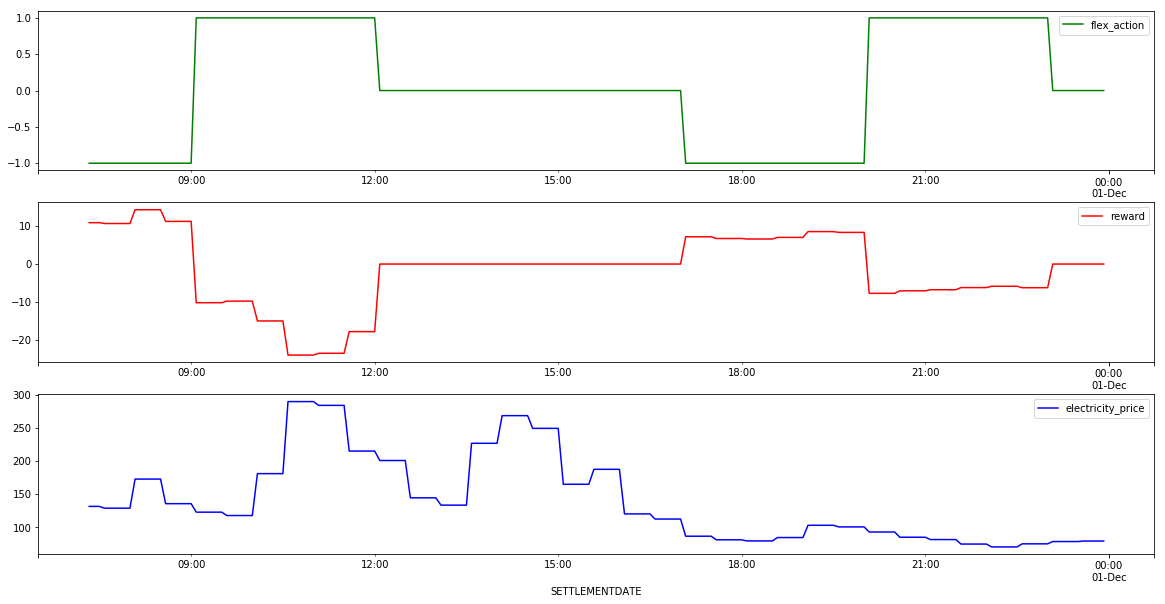

In [4]:
def plot_single_episode(run):
    print('plotting single episode of {}'.format(run.run_name))
    print(' ')
    results = run.results

    selected = random.randint(0, len(results))
    selected = results[selected]

    _ = process_result(selected, verbose=True)

    _ = plot_result(selected)
    
plot_single_episode(runs['naive_flex/time'])

plotting single episode of naive_flex/auto
 
             electricity_price                  flex_up flex_down
                          mean     amax    amin     sum       sum
flex_counter                                                     
0                    30.083388    44.36   17.60       0         0
1                    50.098571    54.00   42.24      21        21
2                    49.875714    52.77   47.02      21        21
3                    44.353333    49.39   41.41      21        21
4                    36.192857    54.95   18.85      21        21
5                    40.495000    43.13   37.86      21        21
6                    35.374444    40.29   32.12      21        21
7                    36.729375    49.14   23.74      21        21
8                    42.670000    47.99   32.07      21        21
9                    32.305000    48.92   24.91      21        21
10                   38.268182    45.52   33.88      21        21
11                   29.042174 

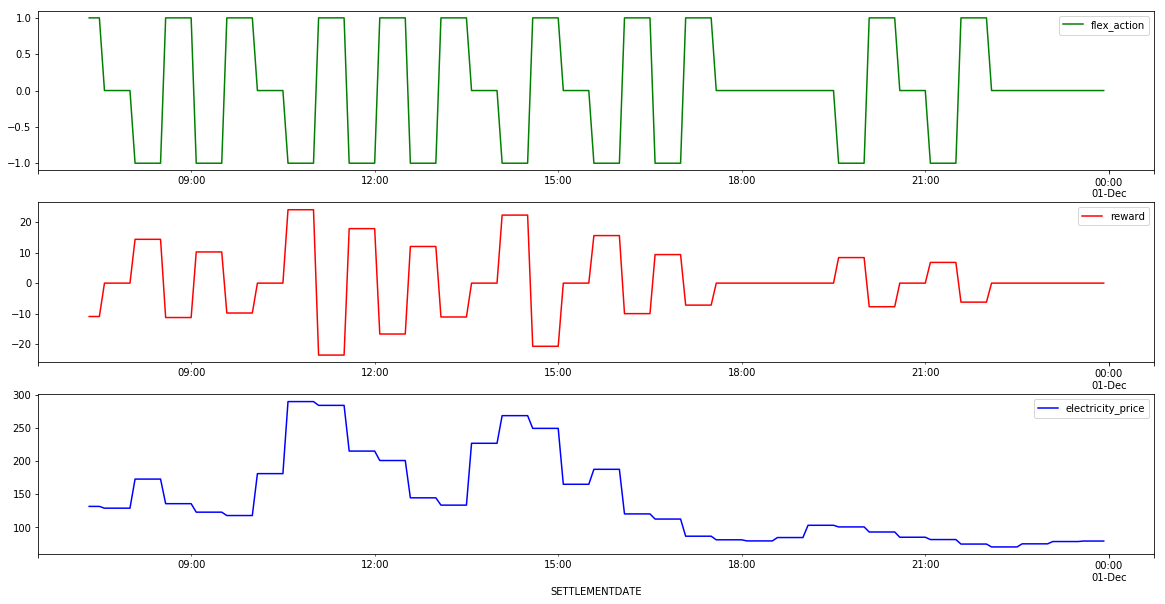

In [7]:
plot_single_episode(runs['naive_flex/auto'])